# libraries

In [ ]:
import os
from google.cloud import bigquery
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import json
from functools import reduce
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Absolute path to your key
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/tolgasabanoglu/Desktop/github/spatiotemporal/spatiotemporal-key.json"

# Initialize BigQuery client
client = bigquery.Client()

In [3]:
table_id = f"{client.project}.garmin_data.garmin_raw_data"
df = client.query(f"SELECT * FROM `{table_id}`").to_dataframe()
df

/Users/tolgasabanoglu/Desktop/github/spatiotemporal/spatiotemporal_env/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,filename,raw_json
0,body_battery_2025-09-22.json,"[{""date"": ""2025-09-22"", ""charged"": 45, ""draine..."
1,heart_rate_2025-04-17.json,"{""userProfilePK"": 130724645, ""calendarDate"": ""..."
2,body_battery_2025-05-01.json,"[{""date"": ""2025-05-01"", ""charged"": 36, ""draine..."
3,sleep_2025-04-15.json,"{""dailySleepDTO"": {""id"": 1744676720000, ""userP..."
4,sleep_2025-06-28.json,"{""dailySleepDTO"": {""id"": 1751058151000, ""userP..."
...,...,...
5704,steps_2025-09-19.json,"[{""startGMT"": ""2025-09-18T15:00:00.0"", ""endGMT..."
5705,steps_2025-07-07.json,"[{""startGMT"": ""2025-07-06T22:00:00.0"", ""endGMT..."
5706,stress_2025-09-12.json,"{""userProfilePK"": 130724645, ""calendarDate"": ""..."
5707,stress_2025-06-21.json,"{""userProfilePK"": 130724645, ""calendarDate"": ""..."


In [4]:
# Identify the type of JSON structure
def detect_json_type(raw):
    try:
        obj = json.loads(raw)
        if isinstance(obj, list):
            return 'list'
        elif isinstance(obj, dict):
            return 'dict'
        else:
            return 'other'
    except Exception:
        return 'invalid'

df['json_type'] = df['raw_json'].apply(detect_json_type)

# See how many of each type we have
print(df['json_type'].value_counts())

# Peek at unique filename prefixes (the metric types)
df['metric'] = df['filename'].str.extract(r'^([^_]+)')
print(df['metric'].value_counts())


json_type
dict    3429
list    2280
Name: count, dtype: int64
metric
body      1143
heart     1143
sleep     1143
stress    1143
steps     1137
Name: count, dtype: int64


In [5]:
# Copy the original dataframe
df_clean = df.copy()

# Function to normalize JSON
def normalize_json(x):
    if isinstance(x, str):
        x = json.loads(x)  # parse JSON string
    if isinstance(x, list):
        return pd.DataFrame(x)  # explode list of dicts
    elif isinstance(x, dict):
        return pd.DataFrame([x])  # wrap dict in a DataFrame
    else:
        return pd.DataFrame()  # empty fallback

# Create a dictionary to hold separate tidy dfs by filename prefix
tidy_dfs = {}

# Loop through unique filename prefixes (everything before the first '_')
for prefix in df_clean['filename'].str.split('_').str[0].unique():
    df_subset = df_clean[df_clean['filename'].str.startswith(prefix)]
    temp_list = []
    
    for _, row in df_subset.iterrows():
        temp_df = normalize_json(row['raw_json'])
        if not temp_df.empty:
            temp_df['filename'] = row['filename']  # keep filename
            temp_list.append(temp_df)
    
    if temp_list:
        tidy_dfs[prefix] = pd.concat(temp_list, ignore_index=True)

# Now tidy_dfs contains:
# keys: 'body', 'heart', 'sleep', 'stress', 'steps'
# values: the corresponding tidy DataFrames
# Example: inspect the first few rows of body_battery
tidy_dfs.keys()


dict_keys(['body', 'heart', 'sleep', 'stress', 'steps'])

# df structure

In [6]:

def get_all_column_names(dataframes: dict) -> None:
    """
    Iterates through a dictionary of DataFrames and prints the column names 
    for each one, displayed as a single, comma-separated list.
    
    Args:
        dataframes: A dictionary where keys are dataset names (str) and values 
                    are pandas DataFrames.
    """
    print("-" * 50)
    print("Dataset Column Inspection")
    print("-" * 50)

    for name, df in dataframes.items():
        # Using f-strings to format the output nicely
        print(f"\n[{name.upper()} Dataset ({len(df)} rows)]")
        
        # Check if the object is actually a DataFrame before getting columns
        if isinstance(df, pd.DataFrame):
            columns = df.columns.tolist()
            # Join all column names into a single comma-separated string for easy viewing
            print("Columns (List):")
            print(f"  {', '.join(columns)}")
        else:
            print("Warning: Item is not a pandas DataFrame.")


# Execute the function
get_all_column_names(tidy_dfs)


--------------------------------------------------
Dataset Column Inspection
--------------------------------------------------

[BODY Dataset (1143 rows)]
Columns (List):
  date, charged, drained, startTimestampGMT, endTimestampGMT, startTimestampLocal, endTimestampLocal, bodyBatteryValuesArray, bodyBatteryValueDescriptorDTOList, bodyBatteryDynamicFeedbackEvent, bodyBatteryActivityEvent, filename, endOfDayBodyBatteryDynamicFeedbackEvent

[HEART Dataset (1143 rows)]
Columns (List):
  userProfilePK, calendarDate, startTimestampGMT, endTimestampGMT, startTimestampLocal, endTimestampLocal, maxHeartRate, minHeartRate, restingHeartRate, lastSevenDaysAvgRestingHeartRate, heartRateValueDescriptors, heartRateValues, filename

[SLEEP Dataset (1143 rows)]
Columns (List):
  dailySleepDTO, sleepMovement, remSleepData, sleepLevels, sleepRestlessMoments, restlessMomentsCount, wellnessEpochRespirationDataDTOList, wellnessEpochRespirationAveragesList, respirationVersion, sleepHeartRate, sleepStress, s

# merging

In [7]:
# -----------------------------
# Step 1: Columns to keep per dataset
# -----------------------------
body_cols = ['charged', 'drained', 'bodyBatteryDynamicFeedbackEvent', 
             'bodyBatteryActivityEvent', 'endOfDayBodyBatteryDynamicFeedbackEvent']
heart_cols = ['maxHeartRate', 'minHeartRate', 'restingHeartRate', 
              'lastSevenDaysAvgRestingHeartRate', 'heartRateValueDescriptors', 'heartRateValues']
sleep_cols = ['dailySleepDTO', 'sleepMovement', 'remSleepData', 'sleepLevels', 
              'sleepRestlessMoments', 'restlessMomentsCount', 'wellnessEpochRespirationAveragesList',
              'respirationVersion', 'sleepHeartRate', 'sleepStress', 'sleepBodyBattery', 
              'hrvData', 'avgOvernightHrv', 'hrvStatus', 'bodyBatteryChange']
stress_cols = ['maxStressLevel', 'avgStressLevel', 'stressChartValueOffset']
steps_cols = ['steps', 'pushes', 'primaryActivityLevel', 'activityLevelConstant']

# -----------------------------
# Step 2: Function to extract date from filename
# -----------------------------
def extract_date_from_filename(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['filename'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0], errors='coerce')
    return df

# -----------------------------
# Step 3: Flatten array/dict columns
# -----------------------------
array_columns = [
    'bodyBatteryDynamicFeedbackEvent', 'bodyBatteryActivityEvent', 'endOfDayBodyBatteryDynamicFeedbackEvent', 
    'heartRateValueDescriptors', 'heartRateValues', 'dailySleepDTO', 'sleepMovement', 'sleepLevels',
    'sleepRestlessMoments', 'wellnessEpochRespirationAveragesList', 'sleepHeartRate', 'sleepStress', 'sleepBodyBattery',
    'hrvData', 'stressValuesArray'
]

def flatten_and_aggregate(arr):
    """Safely flatten list/array of lists or dicts and compute mean."""
    # Check if arr is a scalar missing value
    if arr is None or (np.isscalar(arr) and pd.isna(arr)):
        return np.nan

    # If it's a single-element array (e.g., np.array, pd.Series), convert to list
    if isinstance(arr, (np.ndarray, pd.Series)):
        arr = arr.tolist()
    
    # Ensure arr is iterable
    if not isinstance(arr, list):
        return np.nan

    values = []
    for item in arr:
        # list like [timestamp, value]
        if isinstance(item, list) and len(item) > 1 and isinstance(item[1], (int, float)):
            values.append(item[1])
        # dict with 'value' key
        elif isinstance(item, dict) and 'value' in item:
            val = item['value']
            if isinstance(val, (int, float)):
                values.append(val)
    return np.mean(values) if values else np.nan


# -----------------------------
# Step 4: Extract date, select columns, flatten arrays
# -----------------------------
def prepare_df(df, cols):
    df_sel = extract_date_from_filename(df)[cols + ['date']].copy()
    for col in array_columns:
        if col in df_sel.columns:
            df_sel[col + '_mean'] = df_sel[col].apply(flatten_and_aggregate)
            df_sel.drop(columns=[col], inplace=True)
    return df_sel

body_df = prepare_df(tidy_dfs['body'], body_cols)
heart_df = prepare_df(tidy_dfs['heart'], heart_cols)
sleep_df = prepare_df(tidy_dfs['sleep'], sleep_cols)
stress_df = prepare_df(tidy_dfs['stress'], stress_cols)
steps_df = prepare_df(tidy_dfs['steps'], steps_cols)

# -----------------------------
# Step 5: Merge all datasets on 'date'
# -----------------------------
daily_dfs = [body_df, heart_df, sleep_df, stress_df, steps_df]
merged_daily = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), daily_dfs)

# -----------------------------
# Step 6: Aggregate per day
# -----------------------------
def daily_aggregate(df):
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    other_cols = [c for c in df.columns if c not in numeric_cols + ['date']]
    
    agg_dict = {col: 'mean' for col in numeric_cols}
    for col in other_cols:
        agg_dict[col] = 'first'
    
    return df.groupby('date', as_index=False).agg(agg_dict)

merged_daily_agg = daily_aggregate(merged_daily)

# -----------------------------
# Step 7: Inspect final dataset
# -----------------------------
print(f"Aggregated daily dataset: {merged_daily_agg.shape[0]} rows, {merged_daily_agg.shape[1]} columns")
merged_daily_agg.head()


Aggregated daily dataset: 233 rows, 34 columns


,date,bodyBatteryDynamicFeedbackEvent_mean,bodyBatteryActivityEvent_mean,endOfDayBodyBatteryDynamicFeedbackEvent_mean,heartRateValueDescriptors_mean,heartRateValues_mean,restlessMomentsCount,respirationVersion,avgOvernightHrv,bodyBatteryChange,...,minHeartRate,restingHeartRate,lastSevenDaysAvgRestingHeartRate,remSleepData,hrvStatus,maxStressLevel,avgStressLevel,stressChartValueOffset,primaryActivityLevel,activityLevelConstant
0,2025-02-25,NaN,NaN,NaN,NaN,85.010638,NaN,NaN,NaN,NaN,...,69,75,75,None,None,96,54,1,none,True
1,2025-02-26,NaN,NaN,NaN,NaN,86.863889,32.0,200.0,33.0,51.0,...,59,64,70,True,NONE,97,46,1,sleeping,True
2,2025-02-27,NaN,NaN,NaN,NaN,83.918803,41.0,200.0,27.0,28.0,...,63,68,69,True,NONE,96,43,1,sleeping,True
3,2025-02-28,NaN,NaN,NaN,NaN,79.884498,42.0,200.0,42.0,86.0,...,56,59,67,True,NONE,99,25,1,sleeping,True
4,2025-03-01,NaN,NaN,NaN,NaN,85.211949,35.0,200.0,36.0,54.0,...,56,60,65,True,NONE,99,37,1,sleeping,True


# cleaning

## check the missing columns

In [8]:
# === Missing Values (>50%) ===
missing_ratio = merged_daily_agg.isna().mean() * 100  # percentage of missing
missing_over_50 = missing_ratio[missing_ratio > 50].sort_values(ascending=False)

print("=== Columns with >50% Missing Values ===")
if missing_over_50.empty:
    print("✅ No columns have more than 50% missing values.")
else:
    print(missing_over_50.to_string(float_format="%.2f"))

=== Columns with >50% Missing Values ===
bodyBatteryDynamicFeedbackEvent_mean           100.00
bodyBatteryActivityEvent_mean                  100.00
endOfDayBodyBatteryDynamicFeedbackEvent_mean   100.00
heartRateValueDescriptors_mean                 100.00
dailySleepDTO_mean                             100.00
sleepMovement_mean                             100.00
sleepLevels_mean                               100.00
wellnessEpochRespirationAveragesList_mean      100.00


## fill the missing columns

In [ ]:
# === 2. Find and Drop Columns with >50% Missing Values ===
missing_ratio = merged_daily_agg.isna().mean() * 100
cols_to_drop = missing_ratio[missing_ratio > 50].index.tolist()

# Add columns with only one unique value
constant_cols = merged_daily_agg.columns[merged_daily_agg.nunique() <= 1].tolist()
cols_to_drop.extend(constant_cols)

# Remove duplicates if any
cols_to_drop = list(set(cols_to_drop))

print("=== Dropping Columns with >50% Missing Values or Single Constant Value ===")
print(cols_to_drop)

merged_daily_agg = merged_daily_agg.drop(columns=cols_to_drop)
print(f"\n✅ Dropped {len(cols_to_drop)} columns. Remaining columns: {merged_daily_agg.shape[1]}")

# === 3. Fill Missing Values for Remaining Columns ===
for col in merged_daily_agg.columns:
    dtype = merged_daily_agg[col].dtype

    if np.issubdtype(dtype, np.number):
        # Numeric → median
        median_val = merged_daily_agg[col].median()
        merged_daily_agg[col] = merged_daily_agg[col].fillna(median_val)

    elif dtype == 'O':
        # Object → mode or "Unknown"
        mode_val = merged_daily_agg[col].mode()
        fill_val = mode_val[0] if not mode_val.empty else "Unknown"
        merged_daily_agg[col] = merged_daily_agg[col].fillna(fill_val)

    elif np.issubdtype(dtype, np.datetime64):
        # Datetime → forward fill then backward fill
        merged_daily_agg[col] = merged_daily_agg[col].ffill().bfill()

print("\n✅ Missing values handled successfully (no warnings).")
print(f"✅ Final shape: {merged_daily_agg.shape}")
print(f"✅ Remaining missing values total: {merged_daily_agg.isna().sum().sum()}")


=== Dropping Columns with >50% Missing Values or Single Constant Value ===
['remSleepData', 'respirationVersion', 'stressChartValueOffset', 'endOfDayBodyBatteryDynamicFeedbackEvent_mean', 'bodyBatteryDynamicFeedbackEvent_mean', 'bodyBatteryActivityEvent_mean', 'dailySleepDTO_mean', 'wellnessEpochRespirationAveragesList_mean', 'sleepMovement_mean', 'pushes', 'heartRateValueDescriptors_mean', 'sleepLevels_mean']

✅ Dropped 12 columns. Remaining columns: 22

✅ Missing values handled successfully (no warnings).
✅ Final shape: (233, 22)
✅ Remaining missing values total: 0


/var/folders/1g/45y5svr534s7c8sx09294sxc0000gn/T/ipykernel_9318/3506003875.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_daily_agg[col] = merged_daily_agg[col].fillna(fill_val)


## data str

In [10]:
print("=== Columns and Data Types ===")
for col, dtype in merged_daily_agg.dtypes.items():
    print(f"{col:40}  {dtype}")


=== Columns and Data Types ===
date                                      datetime64[ns]
heartRateValues_mean                      float64
restlessMomentsCount                      float64
avgOvernightHrv                           float64
bodyBatteryChange                         float64
sleepRestlessMoments_mean                 float64
sleepHeartRate_mean                       float64
sleepStress_mean                          float64
sleepBodyBattery_mean                     float64
hrvData_mean                              float64
steps                                     float64
charged                                   int64
drained                                   int64
maxHeartRate                              int64
minHeartRate                              int64
restingHeartRate                          int64
lastSevenDaysAvgRestingHeartRate          int64
hrvStatus                                 object
maxStressLevel                            int64
avgStressLevel             

# pca, feature space

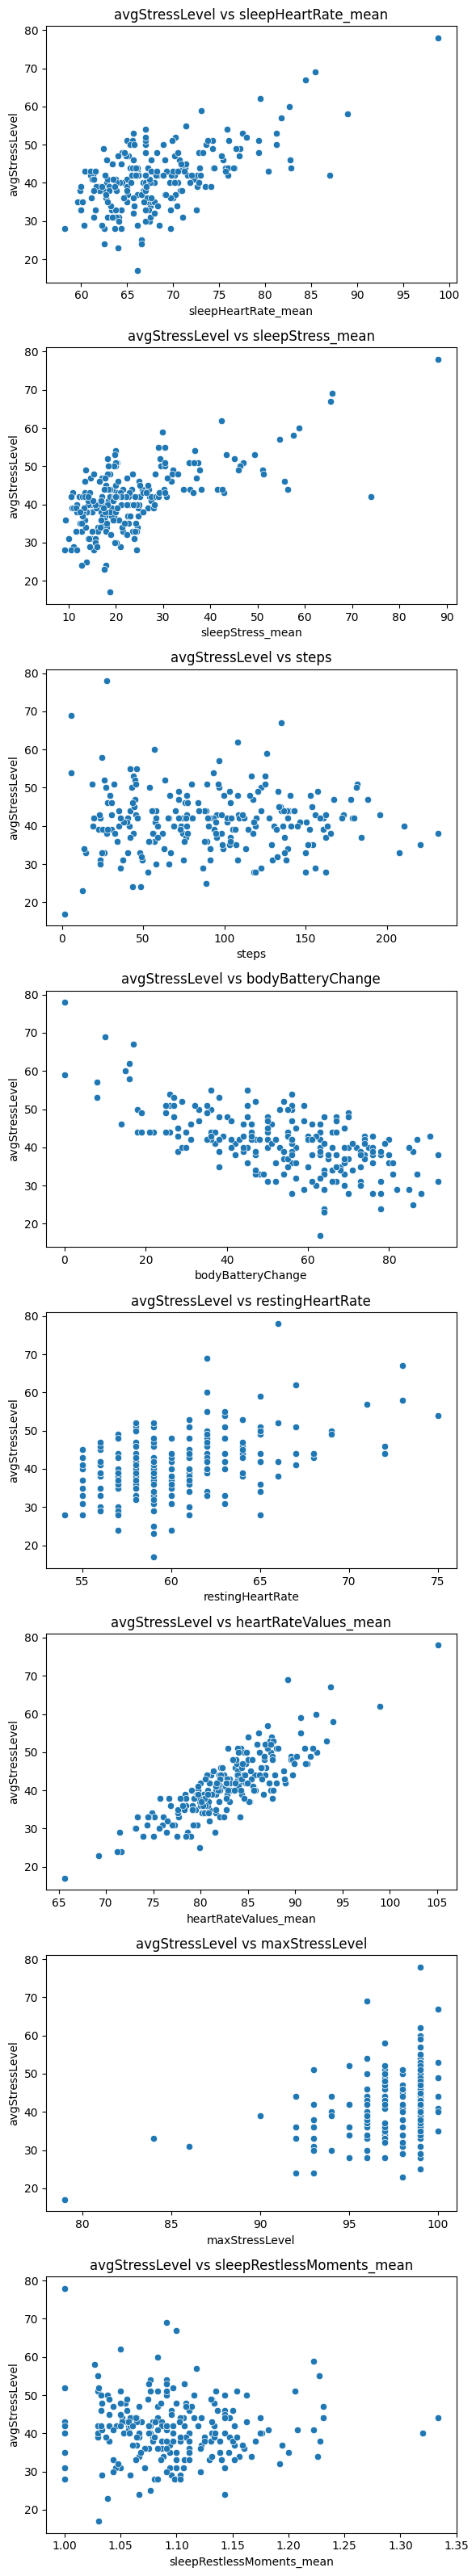

In [ ]:
# Define x variables
x_vars = [
    'sleepHeartRate_mean', 
    'sleepStress_mean', 
    'steps', 
    'bodyBatteryChange', 
    'restingHeartRate', 
    'heartRateValues_mean', 
    'maxStressLevel',
    'sleepRestlessMoments_mean'
]

# Create a figure
fig, axes = plt.subplots(len(x_vars), 1, figsize=(6, 4 * len(x_vars)))

# Plot each scatter plot
for i, x in enumerate(x_vars):
    sns.scatterplot(data=merged_daily_agg, x=x, y='avgStressLevel', ax=axes[i])
    axes[i].set_title(f'avgStressLevel vs {x}')
    axes[i].set_xlabel(x)
    axes[i].set_ylabel('avgStressLevel')

plt.tight_layout()
plt.show()


The data suggests that daily stress is most closely tied to other stress-related metrics and heart rate, while activity (steps) and some sleep parameters (restless moments) show weaker connections. The most effective way to lower the average stress level appears to be maximizing Body Battery Change (recovery).


Analyzing 17 numeric features...

--- Explained Variance Ratio ---
PC 1: 48.43% variance explained (Cumulative: 48.43%)
PC 2: 13.16% variance explained (Cumulative: 61.59%)
PC 3: 6.95% variance explained (Cumulative: 68.54%)
PC 4: 6.20% variance explained (Cumulative: 74.74%)
PC 5: 5.00% variance explained (Cumulative: 79.74%)
...


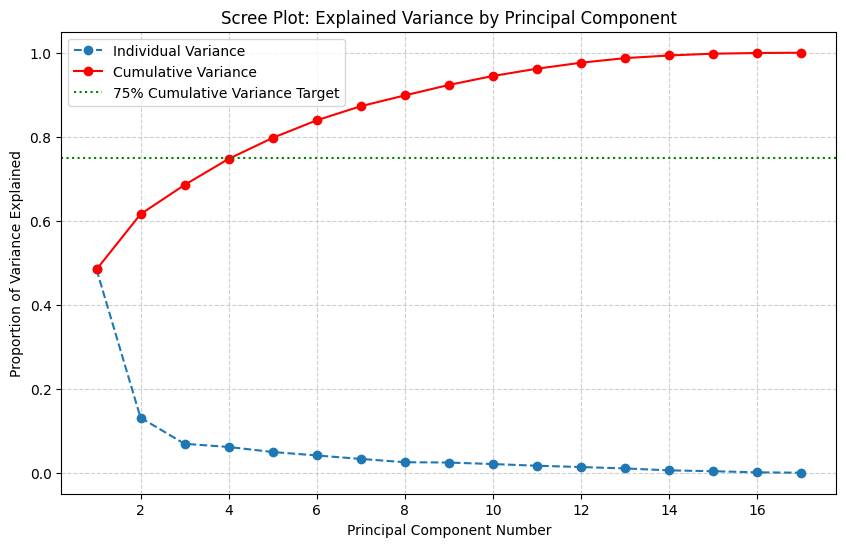


--- Component Loadings (Focus on PC1 and PC2) ---
Interpretation Key:
 - A large POSITIVE loading means the feature contributes heavily to the PC in a positive direction.
 - A large NEGATIVE loading means the feature contributes heavily to the PC in a negative direction.
 - Values near 0 mean the feature has little influence on that PC.
--------------------------------------------------
                                   PC 1   PC 2
sleepHeartRate_mean               0.325 -0.003
sleepStress_mean                  0.310  0.016
restingHeartRate                  0.287 -0.070
minHeartRate                      0.276 -0.040
heartRateValues_mean              0.224  0.392
lastSevenDaysAvgRestingHeartRate  0.146 -0.121
maxStressLevel                   -0.000  0.509
steps                            -0.006  0.493
maxHeartRate                     -0.006  0.528
sleepRestlessMoments_mean        -0.025  0.028
restlessMomentsCount             -0.105 -0.115
sleepBodyBattery_mean            -0.291 -0.03

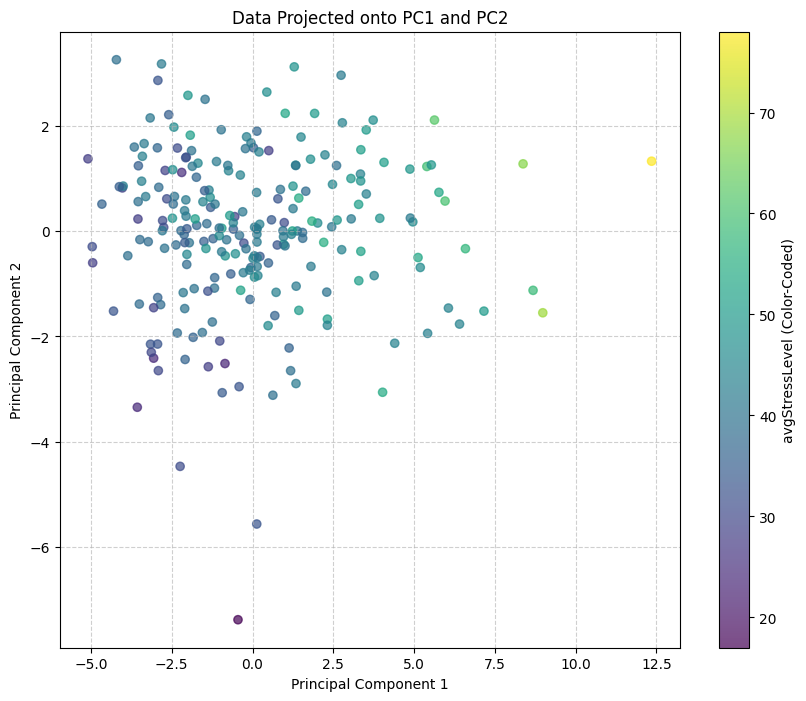

In [ ]:
# --- 2. DATA PREPARATION ---

# Separate the potential response variable (Y) from the predictors (X)
Y = merged_daily_agg['avgStressLevel']

# The TypeError indicates non-numeric columns (like Date/ID) are present.
# We explicitly select only numeric columns for PCA and standardization.
# We also drop the target variable 'avgStressLevel'.
X = merged_daily_agg.drop(columns=['avgStressLevel'], errors='ignore')
X = X.select_dtypes(include=np.number)
feature_names = X.columns

print(f"\nAnalyzing {len(feature_names)} numeric features...")

# Standardize the features (Mean=0, StdDev=1)
# This is crucial for PCA as it's sensitive to scale.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. APPLY PCA ---

# Instantiate PCA (using None means we keep all components initially)
pca = PCA(n_components=None)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

# --- 4. EXPLAINED VARIANCE (SCREE PLOT) ---

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print("\n--- Explained Variance Ratio ---")
for i, (evr, cv) in enumerate(zip(explained_variance_ratio[:5], cumulative_variance[:5])):
    print(f"PC {i+1}: {evr*100:.2f}% variance explained (Cumulative: {cv*100:.2f}%)")
print("...")

# Plotting the Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', label='Individual Variance')
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='-', color='red', label='Cumulative Variance')
plt.title('Scree Plot: Explained Variance by Principal Component')
plt.xlabel('Principal Component Number')
plt.ylabel('Proportion of Variance Explained')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(y=0.75, color='green', linestyle=':', label='75% Cumulative Variance Target')
plt.legend()
plt.show() # 

# --- 5. INTERPRETATION: FEATURE LOADINGS ---

# Create a DataFrame for easier inspection of loadings
# The loadings (or components) show how much each original feature contributes to the new PC.
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC {i+1}' for i in range(X_pca.shape[1])],
    index=feature_names
)

print("\n--- Component Loadings (Focus on PC1 and PC2) ---")
print("Interpretation Key:")
print(" - A large POSITIVE loading means the feature contributes heavily to the PC in a positive direction.")
print(" - A large NEGATIVE loading means the feature contributes heavily to the PC in a negative direction.")
print(" - Values near 0 mean the feature has little influence on that PC.")
print("-" * 50)

# Display the top features driving the first two principal components
# We use .round(3) for cleaner output.
print(loadings[['PC 1', 'PC 2']].sort_values(by='PC 1', ascending=False).round(3))

# --- 6. OPTIONAL: VISUALIZING THE DATA IN 2D ---

# Scatter plot of the first two components
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y, cmap='viridis', alpha=0.7)
plt.colorbar(label='avgStressLevel (Color-Coded)')
plt.title('Data Projected onto PC1 and PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show() # 



 **Explained Variance Ratio** tells us how much of the total variability in your 17-dimensional dataset is captured by each new component.

| Component | Individual Variance Explained | Cumulative Variance Explained | Interpretation |
|-----------|-------------------------------|-------------------------------|----------------|
| PC 1      | 48.43%                        | 48.43%                        | Captures the single largest source of variation. |
| PC 2      | 13.16%                        | 61.59%                        | Adds the second major independent dimension. |
| PC 3      | 6.95%                         | 68.54%                        | - |
| PC 4      | 6.20%                         | 74.74%                        | Reaches the target threshold. |
| PC 5      | 5.00%                         | 79.74%                        | - |

**Conclusion on Components to Keep:**  
- **PC 1** is overwhelmingly the most important factor, capturing nearly half of all the information in your data.  
- The cumulative variance hits the 75% target threshold with **PC 4**.  
- For deep interpretation and practical modeling, focusing on **PC 1, PC 2, PC 3, and PC 4** is sufficient to represent nearly three-quarters of your data's complexity.

---

The **Loadings** reveal the underlying factors by showing which original variables are highly correlated with the new Principal Components.

PC 1 (48.43% Variance) is a composite measure of **Physiological Rest & Recovery vs. Strain**.

| Feature                | PC 1 Loading | Interpretation         |
|------------------------|--------------|-----------------------|
| sleepHeartRate_mean     | +0.325       | High Positive Loading |
| sleepStress_mean        | +0.310       | High Positive Loading |
| bodyBatteryChange       | -0.314       | High Negative Loading |
| hrvData_mean            | -0.314       | High Negative Loading |
| avgOvernightHrv         | -0.310       | High Negative Loading |
| sleepBodyBattery_mean   | -0.291       | High Negative Loading |

**Interpretation:**  
- **High PC 1 Score (↑):** Corresponds to high heart rate metrics (sleepHeartRate_mean, sleepStress_mean, restingHeartRate). Represents a state of **High Strain or Poor Recovery**.  
- **Low PC 1 Score (↓):** Corresponds to high recovery metrics (hrvData_mean, avgOvernightHrv, bodyBatteryChange). Represents a state of **Good Recovery or Low Strain**.

---


PCA is **unsupervised**: When the model calculated **PC 1** and **PC 2**, it only looked at the relationships among your 17 features (\(X\)). It had **no idea** that **avgStressLevel (\(Y\))** even existed.  

The plot is a **supervised exploration**: By coloring the points using **avgStressLevel** after the PCA is done, we are essentially asking,  

> "Do the underlying factors (PC 1 and PC 2) happen to align with the stress level we are trying to predict?"

The interpretation of the plot is based on observing the **color gradient pattern** across the dimensions:

- **Strong alignment with PC 1 (horizontal movement):**  
  - The purple/dark blue points (low stress, 20–40) are clustered on the **left side** (low PC 1 values).  
  - The bright green/yellow points (high stress, 60–70+) are scattered towards the **right side** (high PC 1 values).  

  **Conclusion:** This gradient confirms the numerical loadings of **PC 1**. The **"Physiological Strain / Poor Recovery"** factor captured by PC 1 is the **primary underlying factor** driving avgStressLevel.  
  - **High PC 1 values** → highly associated with **high stress**.

- **Weak alignment with PC 2 (vertical movement):**  
  - If PC 2 were strongly related to stress, there would be a **strong vertical color gradient** (e.g., all yellow points at the top, all purple points at the bottom).  
  - In your plot, the colors are **mixed vertically**. High-stress yellow points appear at **both the top and bottom** of the component space.  

  **Conclusion:**  
  - **PC 2 ("Max Exertion")** is largely **independent** of average stress.  
  - Days with **high max exertion** could result in either **high or low average stress**, depending mostly on **strain/recovery status (PC 1)**.


# ml/dl

In [ ]:
import sys
sys.path.append("/Users/tolgasabanoglu/Desktop/github/spatiotemporal/notebooks/")

# Load your algorithm script
import importlib
import algorithms  # assuming the file is algorithms.py
from algorithms import logistic_reg

importlib.reload(algorithms)


<module 'algorithms' from '/Users/tolgasabanoglu/Desktop/github/spatiotemporal/notebooks/algorithms.py'>

## random forest

Fitting 3 folds for each of 108 candidates, totalling 324 fits


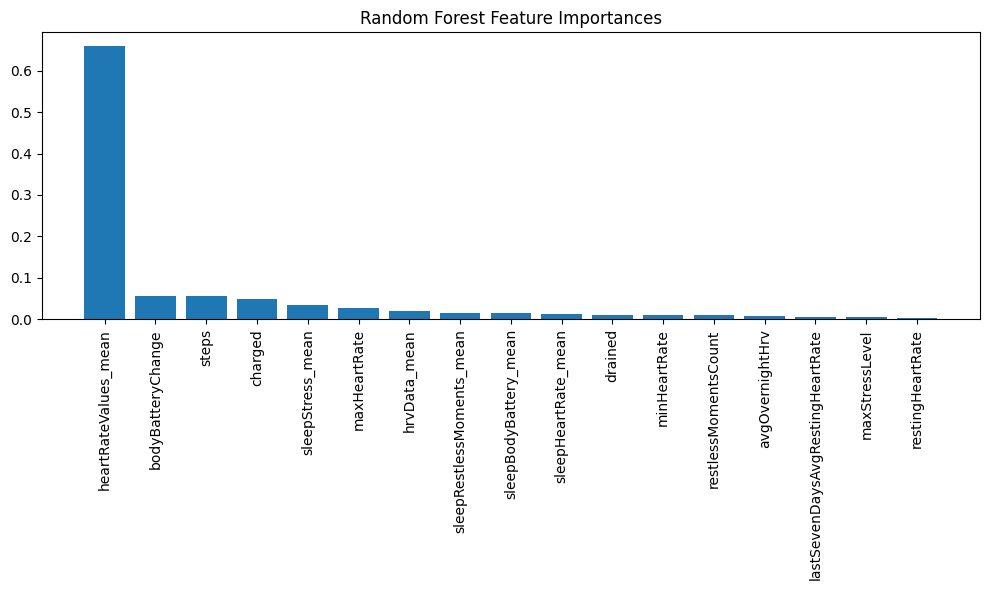

Best RF Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
{'r2': 0.805131182726748, 'rmse': np.float64(3.323796627503594), 'mae': 2.6631430190153678}


In [16]:
# Features
target = 'avgStressLevel'
features = merged_daily_agg.select_dtypes(include=['int64','float64']).columns.tolist()
features = [f for f in features if f != target]

# Random Forest
rf_results = algorithms.train_random_forest(merged_daily_agg, target, features)
print(rf_results['metrics'])

- Predictive Power is High: An $R^2$ of 80.5% is considered excellent for a human health metric, where daily variability and unmeasured factors (like mood, job stress, etc.) are always present.
- Error is Low: An average error of 2.66 points is highly useful, especially if your stress scale is large (e.g., 0-100).

-  Feature importance:

    - heartRateValues_mean (Dominant Factor): This single feature is, by far, the most important predictor, explaining over 60% of the model's predictive power.

    - bodyBatteryChange: The net change in energy is the second most important.

    - steps and charged: These follow as secondary, but still significant, contributors.


## logistic regression

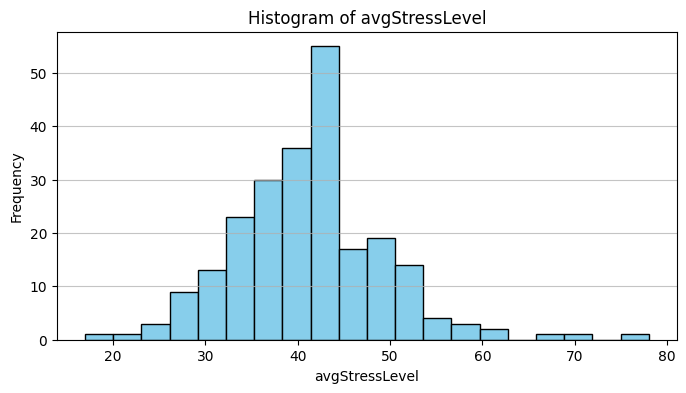

In [17]:
# Assuming merged_daily_agg is already loaded
plt.figure(figsize=(8,4))
plt.hist(merged_daily_agg['avgStressLevel'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of avgStressLevel')
plt.xlabel('avgStressLevel')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


Garmin stress level is a feature that measures your body's stress based on heart rate variability (HRV) while you are inactive. The score ranges from 0 to 100, with 0–25 being a resting state, 26–50 low stress, 51–75 medium stress, and 76–100 high stress.


Training Accuracy: 0.983

Logistic Regression Model Summary:
                             Feature  Coefficient  OddsRatio
0               heartRateValues_mean     1.795936   6.025109
1               restlessMomentsCount     0.076404   1.079399
2                    avgOvernightHrv     0.040165   1.040982
3                  bodyBatteryChange    -0.209605   0.810904
4          sleepRestlessMoments_mean     0.014996   1.015109
5                sleepHeartRate_mean    -0.622065   0.536835
6                   sleepStress_mean     0.311787   1.365863
7              sleepBodyBattery_mean     0.129767   1.138563
8                       hrvData_mean     0.083196   1.086754
9                              steps    -0.057383   0.944233
10                           charged    -0.063190   0.938765
11                           drained    -0.047384   0.953721
12                      maxHeartRate    -0.134138   0.874469
13                      minHeartRate    -0.515417   0.597251
14                  rest

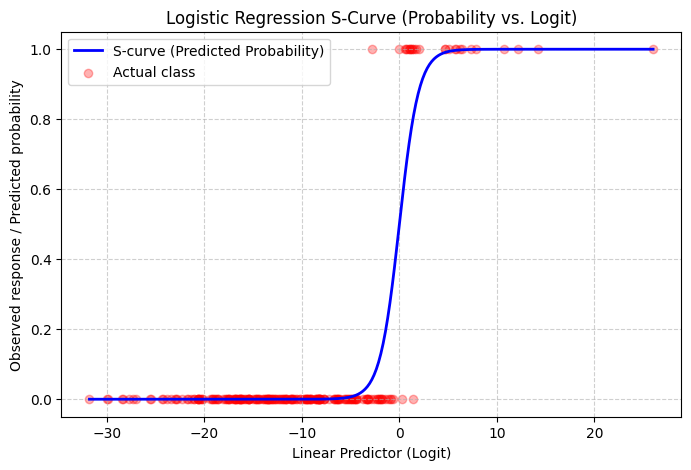

In [ ]:
# Create binary column only if it doesn't exist
if 'stress_binary' not in merged_daily_agg.columns:
    merged_daily_agg['stress_binary'] = (merged_daily_agg['avgStressLevel'] > 50).astype(int)


# Logistic regression
model = logistic_reg(
    merged_daily_agg,
    y='stress_binary',
    x=features
)


The model predicts a Positive Outcome (Y=1) when avgStressLevel > 50 (High Stress) and a Negative Outcome (Y=0) when avgStressLevel ≤ 50 (Low/Normal Stress). With a threshold of avgStressLevel > 50, the model demonstrates strong performance, achieving a training accuracy of 0.983 (98.3%), indicating it distinguishes High Stress days from Low/Normal Stress days very well within the training data. The S-Curve plot shows a steep slope around Logit = 0, meaning a small change in the combined predictor score (Logit) can flip the prediction from Low/Normal Stress (P ≈ 0) to High Stress (P ≈ 1).

The intercept (b0 = -63.5559) implies that when all health metrics are zero (an unrealistic scenario), the log-odds of a day being High Stress is extremely negative, so the predicted probability of High Stress is essentially zero. This reflects the assumption that stress is generally low unless driven up by other features.

Key predictors increasing the odds of a High Stress day (avgStressLevel > 50) include: heartRateValues_mean with a coefficient of 1.796 and odds ratio (OR) 6.025, meaning a one-unit increase in mean heart rate multiplies the odds of High Stress by six. sleepStress_mean (coefficient 0.312, OR 1.366) increases the odds by 36.6%, while lastSevenDaysAvgRestingHeartRate (coefficient 0.309, OR 1.362) also raises the odds by 36.2%, suggesting chronic physiological strain is a risk factor. sleepBodyBattery_mean (coefficient 0.130, OR 1.139) slightly increases the odds by 13.9%, which is somewhat counter-intuitive and may require further investigation.

Conversely, features associated with lower odds of High Stress (avgStressLevel ≤ 50) include: sleepHeartRate_mean (coefficient -0.622, OR 0.537), where higher sleep heart rate appears protective; minHeartRate (coefficient -0.515, OR 0.597) reducing odds by 40.3%; restingHeartRate (coefficient -0.252, OR 0.777) decreasing odds by 22.3%; and bodyBatteryChange (coefficient -0.210, OR 0.811), with better recovery reducing odds by 18.9%. Interestingly, lower heart rates during sleep are associated with higher stress, which is counter-intuitive.

In summary, the highest risk of High Stress is linked to elevated mean heart rate during the day, high sleep stress, and higher average resting heart rate over the previous week. Meanwhile, higher mean and minimum sleep heart rates and current resting heart rate appear protective against High Stress, highlighting some unexpected patterns in physiological stress indicators.